# Getting Started with the Ray Framework

## Introduction

Ray is a general-purpose framework for programming a cluster made by UC Berkeley's RISELab. It enables developers to easily parallelize their Python applications or build new ones, and run them at any scale, from a laptop to a large cluster. It also provides a highly flexible, yet minimalist and easy to use API. 

#### Documentation Reference Links:

Ray official website: https://rise.cs.berkeley.edu/projects/ray/


Ray documentation website: http://ray.readthedocs.io/en/latest/


GitHub repository: https://github.com/ray-project/ray

### Installation
To install Ray, run the following command on DevCloud
>pip install --user Ray --ignore-installed funcsigs


***
## Part 1 - Remote Functions

In this exercise, you will use Ray to execute the functions in parallel to speed it up by defining remote functions.

The standard way to turn a Python function into a remote function is to add the `@ray.remote` decorator. Here is an example.

```python
# A regular Python function.
def regular_function(x):
    return x + 1

# A Ray remote function.
@ray.remote
def remote_function(x):
    return x + 1
```

The differences are the following:

1. **Invocation:** The regular version is called with `regular_function()`, whereas the remote version is called with `remote_function.remote()`.
2. **Return values:** `regular_function` immediately executes and returns `1`, whereas `remote_function` immediately returns an object ID (a future) and then creates a task that will be executed on a worker process. The result can be obtained with `ray.get`.
    ```python
    >>> regular_function(0)
    1

    >>> remote_function.remote(0)
    ObjectID(1c80d6937802cd7786ad25e50caf2f023c95e350)

    >>> ray.get(remote_function.remote(0))
    1
    ```
`ray.get(id)` blocks the computation until the task associated with id has finished running.  

3. **Parallelism:** Invocations of `regular_function` happen **serially**, for example
    ```python
    # These happen serially.
    for _ in range(4):
        regular_function(0)
    ```
    whereas invocations of `remote_function` happen in **parallel**, for example
    ```python
    # These happen in parallel.
    for _ in range(4):
        remote_function.remote(0)
    ```


In [1]:
# Imports

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import numpy as np
import pickle
import ray
import time

#### Start Ray 
By default, Ray does not schedule more tasks concurrently than there are CPUs. This example requires four tasks to run concurrently, so we tell Ray that there are four CPUs. Usually this is not done and Ray computes the number of CPUs using `psutil.cpu_count()`. The argument `ignore_reinit_error=True` just ignores errors if the cell is run multiple times.

The call to `ray.init` starts a number of processes.

In [2]:
ray.init(num_cpus=4, include_webui=False, ignore_reinit_error=True, redis_max_memory=1000000000,
         object_store_memory=10000000000)

2020-07-03 20:33:10,505	INFO resource_spec.py:212 -- Starting Ray with 177.39 GiB memory available for workers and up to 9.31 GiB for objects. You can adjust these settings with ray.init(memory=<bytes>, object_store_memory=<bytes>).


{'node_ip_address': '10.9.1.45',
 'redis_address': '10.9.1.45:47421',
 'object_store_address': '/tmp/ray/session_2020-07-03_20-33-10_502157_12642/sockets/plasma_store',
 'raylet_socket_name': '/tmp/ray/session_2020-07-03_20-33-10_502157_12642/sockets/raylet',
 'webui_url': None,
 'session_dir': '/tmp/ray/session_2020-07-03_20-33-10_502157_12642'}

**EXERCISE:** The function below is slow. Turn it into a remote function using the `@ray.remote` decorator. 

In [3]:
# This function is a proxy for a more interesting and computationally intensive function.
@ray.remote
def slow_function(i):
    time.sleep(1)
    return i

**EXERCISE:** The loop below takes too long. The four function calls could be executed in parallel. Instead of four seconds, it should only take one second. Once `slow_function` has been made a remote function, execute these four tasks in parallel by calling `slow_function.remote()`. Then obtain the results by calling `ray.get` on a list of the resulting object IDs.

In [4]:
# Sleep a little to improve the accuracy of the timing measurements below.
# We do this because workers may still be starting up in the background.
time.sleep(10.0)
start_time = time.time()

results = ray.get([slow_function.remote(i) for i in range(4)])

end_time = time.time()
duration = end_time - start_time

print('The results are {}. This took {} seconds. Run the next cell to see '
      'if the exercise was done correctly.'.format(results, duration))

The results are [0, 1, 2, 3]. This took 1.015228033065796 seconds. Run the next cell to see if the exercise was done correctly.


**NOTE:** If instead of the above assignment to results we used
     `results = [ray.get(slow-function.remote(i)) for i in range(4)]`
     
 then we would not get parallelism. This is because each call to `ray.get(slow-function.remote(i))` will block computation until the remote task completes. 
 
 **VERIFY:** Run some checks to verify that the changes you made to the code were correct. Some of the checks should fail when you initially run the cells. After completing the exercises, the checks should pass.


In [5]:
assert results == [0, 1, 2, 3], 'Did you remember to call ray.get?'
assert duration < 1.1, ('The loop took {} seconds. This is too slow.'
                        .format(duration))
assert duration > 1, ('The loop took {} seconds. This is too fast.'
                      .format(duration))

print('Success! The example took {} seconds.'.format(duration))

Success! The example took 1.015228033065796 seconds.


***
## Part 2 - Parallel Data Processing with Task Dependencies

**GOAL:** The goal of this exercise is to show how to pass object IDs into remote functions to encode dependencies between tasks.

In this exercise, we construct a sequence of tasks, each of which depends on the previous, mimicking a data parallel application. Within each sequence, tasks are executed serially, but multiple sequences can be executed in parallel.

In this exercise, you will use Ray to parallelize the computation below and speed it up.

### Concept for this Exercise - Task Dependencies

Suppose we have a remote function defined as follows.

```python
@ray.remote
def f(x):
    return x
```

Arguments can be passed into remote functions as usual. 

```python
>>> x1_id = f.remote(1)
>>> ray.get(x1_id)
1

>>> x2_id = f.remote([1, 2, 3])
>>> ray.get(x2_id)
[1, 2, 3]
```

**Object IDs** can also be passed into remote functions. When the function actually gets executed, **the argument will be a retrieved as a regular Python object**.

```python
>>> y1_id = f.remote(x1_id)
>>> ray.get(y1_id)
1

>>> y2_id = f.remote(x2_id)
>>> ray.get(y2_id)
[1, 2, 3]
```

So when implementing a remote function, the function should expect a regular Python object regardless of whether the caller passes in a regular Python object or an object ID.

**Task dependencies affect scheduling.** In the example above, the task that creates `y1_id` depends on the task that creates `x1_id`. This has the following implications.

- The second task will not be executed until the first task has finished executing.
- If the two tasks are scheduled on different machines, the output of the first task (the value corresponding to `x1_id`) will be copied over the network to the machine where the second task is scheduled.

These are some helper functions that mimic an example pattern of a data parallel application.

**EXERCISE:** You will need to turn all of these functions into remote functions. When you turn these functions into remote function, you do not have to worry about whether the caller passes in an object ID or a regular object. In both cases, the arguments will be regular objects when the function executes. This means that even if you pass in an object ID, you **do not need to call `ray.get`** inside of these remote functions.


In [6]:
@ray.remote
def load_data(filename):
    time.sleep(0.1)
    return np.ones((1000, 100))


@ray.remote
def normalize_data(data):
    time.sleep(0.1)
    return data - np.mean(data, axis=0)


@ray.remote
def extract_features(normalized_data):
    time.sleep(0.1)
    return np.hstack([normalized_data, normalized_data ** 2])


@ray.remote
def compute_loss(features):
    num_data, dim = features.shape
    time.sleep(0.1)
    return np.sum((np.dot(features, np.ones(dim)) - np.ones(num_data)) ** 2)


assert hasattr(load_data, 'remote'), 'load_data must be a remote function'
assert hasattr(normalize_data, 'remote'), 'normalize_data must be a remote function'
assert hasattr(extract_features, 'remote'), 'extract_features must be a remote function'
assert hasattr(compute_loss, 'remote'), 'compute_loss must be a remote function'

**EXERCISE:** The loop below takes too long. Parallelize the four passes through the loop by turning `load_data`, `normalize_data`, `extract_features`, and `compute_loss` into remote functions and then retrieving the losses with `ray.get`.
 
**NOTE:** You should only use **ONE** call to `ray.get`. For example, the object ID returned by `load_data` should be passed directly into `normalize_data` without needing to be retrieved by the driver.


In [7]:
# Sleep a little to improve the accuracy of the timing measurements below.
time.sleep(2.0)
start_time = time.time()

losses = []
for filename in ['file1', 'file2', 'file3', 'file4']:
    inner_start = time.time()

    data = load_data.remote(filename)
    normalized_data = normalize_data.remote(data)
    features = extract_features.remote(normalized_data)
    loss = compute_loss.remote(features)
    losses.append(loss)

    inner_end = time.time()

    if inner_end - inner_start >= 0.1:
        raise Exception('You may be calling ray.get inside of the for loop! '
                        'Doing this will prevent parallelism from being exposed. '
                        'Make sure to only call ray.get once outside of the for loop.')
losses = ray.get(losses)
print('The losses are {}.'.format(losses) + '\n')
loss = sum(losses)

end_time = time.time()
duration = end_time - start_time

print('The loss is {}. This took {} seconds. Run the next cell to see '
      'if the exercise was done correctly.'.format(loss, duration))

The losses are [1000.0, 1000.0, 1000.0, 1000.0].

The loss is 4000.0. This took 0.4388294219970703 seconds. Run the next cell to see if the exercise was done correctly.


**VERIFY:** Run some checks to verify that the changes you made to the code were correct. Some of the checks should fail when you initially run the cells. After completing the exercises, the checks should pass.

In [8]:
assert loss == 4000
assert duration < 0.8, ('The loop took {} seconds. This is too slow.'
                        .format(duration))
assert duration > 0.4, ('The loop took {} seconds. This is too fast.'
                        .format(duration))

print('Success! The example took {} seconds.'.format(duration))

Success! The example took 0.4388294219970703 seconds.


***
## Part 3 - Introducing Actors

**Goal:** The goal of this exercise is to show how to create an actor and how to call actor methods.

See the documentation on actors at http://ray.readthedocs.io/en/latest/actors.html.

Sometimes you need a "worker" process to have "state". For example, that state might be a neural network, a simulator environment, a counter, or something else entirely. However, remote functions are side-effect free. That is, they operate on inputs and produce outputs, but they don't change the state of the worker they execute on.

Actors are different. When we instantiate an actor, a brand new worker is created, and all methods that are called on that actor are executed on the newly created worker.

This means that with a single actor, no parallelism can be achieved because calls to the actor's methods will be executed one at a time. However, multiple actors can be created and methods can be executed on them in parallel.

### Concepts for this Exercise - Actors

To create an actor, decorate Python class with the `@ray.remote` decorator.

```python
@ray.remote
class Example(object):
    def __init__(self, x):
        self.x = x

    def set(self, x):
        self.x = x

    def get(self):
        return self.x
```

Like regular Python classes, **actors encapsulate state that is shared across actor method invocations**.

Actor classes differ from regular Python classes in the following ways.
1. **Instantiation:** A regular class would be instantiated via `e = Example(1)`. Actors are instantiated via
    ```python
    e = Example.remote(1)
    ```
    When an actor is instantiated, a **new worker process** is created by a local scheduler somewhere in the cluster.
2. **Method Invocation:** Methods of a regular class would be invoked via `e.set(2)` or `e.get()`. Actor methods are invoked differently.
    ```python
    >>> e.set.remote(2)
    ObjectID(d966aa9b6486331dc2257522734a69ff603e5a1c)

    >>> e.get.remote()
    ObjectID(7c432c085864ed4c7c18cf112377a608676afbc3)
    ```
3. **Return Values:** Actor methods are non-blocking. They immediately return an object ID and **they create a task which is scheduled on the actor worker**. The result can be retrieved with `ray.get`.
    ```python
    >>> ray.get(e.set.remote(2))
    None

    >>> ray.get(e.get.remote())
    2
    ```

**EXERCISE:** Change the `Foo` class to be an actor class by using the `@ray.remote` decorator.

In [9]:
@ray.remote
class Foo(object):
    def __init__(self):
        self.counter = 0

    def reset(self):
        self.counter = 0

    def increment(self):
        time.sleep(0.5)
        self.counter += 1
        return self.counter


assert hasattr(Foo, 'remote'), 'You need to turn "Foo" into an actor with @ray.remote.'


**EXERCISE:** Change the intantiations below to create two actors by calling `Foo.remote()`.

In [10]:
# Create two Foo objects.
f1 = Foo.remote()
f2 = Foo.remote()

**EXERCISE:** Parallelize the code below. The two actors can execute methods in parallel (though each actor can only execute one method at a time).


In [11]:
# Sleep a little to improve the accuracy of the timing measurements below.
time.sleep(2.0)
start_time = time.time()

# Reset the actor state so that we can run this cell multiple times without
# changing the results.
f1.reset.remote()
f2.reset.remote()

# We want to parallelize this code. However, it is not straightforward to
# make "increment" a remote function, because state is shared (the value of
# "self.counter") between subsequent calls to "increment". In this case, it
# makes sense to use actors.
results = []
for _ in range(5):
    results.append(f1.increment.remote())
    results.append(f2.increment.remote())

results = ray.get(results)

end_time = time.time()
duration = end_time - start_time

assert not any([isinstance(result, ray.ObjectID) for result in
                results]), 'Looks like "results" is {}. You may have forgotten to call ray.get.'.format(results)

**VERIFY:** Run some checks to verify that the changes you made to the code were correct. Some of the checks should fail when you initially run the cells. After completing the exercises, the checks should pass.

In [12]:
assert results == [1, 1, 2, 2, 3, 3, 4, 4, 5, 5]

assert duration < 3, ('The experiments ran in {} seconds. This is too '
                      'slow.'.format(duration))
assert duration > 2.5, ('The experiments ran in {} seconds. This is too '
                        'fast.'.format(duration))

print('Success! The example took {} seconds.'.format(duration))

Success! The example took 2.5093302726745605 seconds.


***
## Part 4 - Handling Slow Tasks

**GOAL:** The goal of this exercise is to show how to use `ray.wait` to avoid waiting for slow tasks.

See the documentation for ray.wait at https://ray.readthedocs.io/en/latest/api.html#ray.wait.

This script starts 6 tasks, each of which takes a random amount of time to complete. We'd like to process the results in two batches (each of size 3). Change the code so that instead of waiting for a fixed set of 3 tasks to finish, we make the first batch consist of the first 3 tasks that complete. The second batch should consist of the 3 remaining tasks. Do this exercise by using `ray.wait`.

### Concepts for this Exercise - ray.wait

After launching a number of tasks, you may want to know which ones have finished executing. This can be done with `ray.wait`. The function works as follows.

```python
ready_ids, remaining_ids = ray.wait(object_ids, num_returns=1, timeout=None)
```

**Arguments:**
- `object_ids`: This is a list of object IDs.
- `num_returns`: This is maximum number of object IDs to wait for. The default value is `1`.
- `timeout`: This is the maximum amount of time in milliseconds to wait for. So `ray.wait` will block until either `num_returns` objects are ready or until `timeout` milliseconds have passed.

**Return values:**
- `ready_ids`: This is a list of object IDs that are available in the object store.
- `remaining_ids`: This is a list of the IDs that were in `object_ids` but are not in `ready_ids`, so the IDs in `ready_ids` and `remaining_ids` together make up all the IDs in `object_ids`.

Define a remote function that takes a variable amount of time to run.

In [13]:
@ray.remote
def f(i):
    np.random.seed(5 + i)
    x = np.random.uniform(0, 4)
    time.sleep(x)
    return i, time.time()

**EXERCISE:** Using `ray.wait`, change the code below so that `initial_results` consists of the outputs of the first three tasks to complete instead of the first three tasks that were submitted.

In [14]:
# Sleep a little to improve the accuracy of the timing measurements below.
time.sleep(2.0)
start_time = time.time()

# This launches 6 tasks, each of which takes a random amount of time to
# complete.
result_ids = [f.remote(i) for i in range(6)]
# Get one batch of tasks. Instead of waiting for a fixed subset of tasks, we
# should instead use the first 3 tasks that finish.
ready_ids, remaining_ids = ray.wait(result_ids, num_returns=3, timeout=None)
initial_results = ray.get(ready_ids)

end_time = time.time()
duration = end_time - start_time


**EXERCISE:** Change the code below so that `remaining_results` consists of the outputs of the last three tasks to complete.

In [15]:
# Wait for the remaining tasks to complete.
remaining_results = ray.get(remaining_ids)

**VERIFY:** Run some checks to verify that the changes you made to the code were correct. Some of the checks should fail when you initially run the cells. After completing the exercises, the checks should pass.

In [16]:
assert len(initial_results) == 3
assert len(remaining_results) == 3

initial_indices = [result[0] for result in initial_results]
initial_times = [result[1] for result in initial_results]
remaining_indices = [result[0] for result in remaining_results]
remaining_times = [result[1] for result in remaining_results]

assert set(initial_indices + remaining_indices) == set(range(6))

assert duration < 1.5, ('The initial batch of ten tasks was retrieved in '
                        '{} seconds. This is too slow.'.format(duration))

assert duration > 0.8, ('The initial batch of ten tasks was retrieved in '
                        '{} seconds. This is too slow.'.format(duration))

# Make sure the initial results actually completed first.
assert max(initial_times) < min(remaining_times)

print('Success! The example took {} seconds.'.format(duration))

Success! The example took 1.2573692798614502 seconds.


## Part 5 - Speed up Serialization

**GOAL:** The goal of this exercise is to illustrate how to speed up serialization by using `ray.put`.

### Concepts for this Exercise - ray.put

Object IDs can be created in multiple ways.
- They are returned by remote function calls.
- They are returned by actor method calls.
- They are returned by `ray.put`.

When an object is passed to `ray.put`, the object is serialized using the Apache Arrow format (see https://arrow.apache.org/ for more information about Arrow) and copied into a shared memory object store. This object will then be available to other workers on the same machine via shared memory. If it is needed by workers on another machine, it will be shipped under the hood.

**When objects are passed into a remote function, Ray puts them in the object store under the hood.** That is, if `f` is a remote function, the code

```python
x = np.zeros(1000)
f.remote(x)
```

is essentially transformed under the hood to

```python
x = np.zeros(1000)
x_id = ray.put(x)
f.remote(x_id)
```

The call to `ray.put` copies the numpy array into the shared-memory object store, from where it can be read by all of the worker processes (without additional copying). However, if you do something like

```python
for i in range(10):
    f.remote(x)
```

then 10 copies of the array will be placed into the object store. This takes up more memory in the object store than is necessary, and it also takes time to copy the array into the object store over and over. This can be made more efficient by placing the array in the object store only once as follows.

```python
x_id = ray.put(x)
for i in range(10):
    f.remote(x_id)
```

In this exercise, you will speed up the code below and reduce the memory footprint by calling `ray.put` on the neural net weights before passing them into the remote functions.

**WARNING:** This exercise requires a lot of memory to run. If this notebook is running within a Docker container, then the docker container must be started with a large shared-memory file system. This can be done by starting the docker container with the `--shm-size` flag.

In [17]:
neural_net_weights = {'variable{}'.format(i): np.random.normal(size=1000000)
                      for i in range(50)}

Pickle is a common method to serialize Python objects. In the next exercise, we compare performance of Pickle and serializing objects using Ray. If you are not familiar with Pickle, you can learn its basics here: https://wiki.python.org/moin/UsingPickle 

**EXERCISE:** Compare the time required to serialize the neural net weights and copy them into the object store using Ray versus the time required to pickle and unpickle the weights. The big win should be with the time required for *deserialization*.

Note that when you call `ray.put`, in addition to serializing the object, we are copying it into shared memory where it can be efficiently accessed by other workers on the same machine.

**NOTE:** You don't actually have to do anything here other than run the cell below and read the output.

**NOTE:** Sometimes `ray.put` can be faster than `pickle.dumps`. This is because `ray.put` leverages multiple threads when serializing large objects. Note that this is not possible with `pickle`.

In [18]:
print('Ray - serializing')
start = time.time()
x_id = ray.put(neural_net_weights)
print('time: ', time.time() - start)
print('\nRay - deserializing')
start = time.time()
x_val = ray.get(x_id)
print('time: ', time.time() - start)

print('\npickle - serializing')
start = time.time()
serialized = pickle.dumps(neural_net_weights)
print('time: ', time.time() - start)
print('\npickle - deserializing')
start = time.time()
deserialized = pickle.loads(serialized)
print('time: ', time.time() - start)

# Define a remote function which uses the neural net weights.

@ray.remote
def use_weights(weights, i):
    return i

Ray - serializing
time:  0.21324658393859863

Ray - deserializing
time:  0.0017654895782470703

pickle - serializing
time:  0.3982694149017334

pickle - deserializing
time:  0.18682217597961426


**EXERCISE:** In the code below, use `ray.put` to avoid copying the neural net weights to the object store multiple times.

In [19]:
# Sleep a little to improve the accuracy of the timing measurements below.
time.sleep(2.0)
start_time = time.time()

weights = ray.put(neural_net_weights)
results = ray.get([use_weights.remote(weights, i)
                   for i in range(20)])

end_time = time.time()
duration = end_time - start_time


**VERIFY:** Run some checks to verify that the changes you made to the code were correct. Some of the checks should fail when you initially run the cells. After completing the exercises, the checks should pass.

In [20]:
assert results == list(range(20))
assert duration < 1, ('The experiments ran in {} seconds. This is too '
                      'slow.'.format(duration))

print('Success! The example took {} seconds.'.format(duration))

Success! The example took 0.24095559120178223 seconds.


***
## Part 6 - Evaluating The Performance of Ray

The objective of this section is to measure the performance of Ray for a simple
parallel program. A python file named map reduce.py is provided with this
assignment. This program generates an array of size 8, increments each element
by one, computes the sum of the elements and finally outputs the running time
of the program. The only input of the program is the number of the CPUs that
it can use. In this part, you should run this program with different numbers of
CPUs (1, 2, 4, 8) and report the running time of the program in each case. The
running time is printed to the output as total time:

In [2]:
%%bash
python map_reduce.py 1

running map reduce with 1 cpus
Congratulations, the test passed!
Congratulations, the test passed!

calling reduce_parallel_tree
reduce time: 2.114072799682617
total time: 6.136846542358398


2020-07-03 20:36:35,275	INFO resource_spec.py:212 -- Starting Ray with 177.34 GiB memory available for workers and up to 9.31 GiB for objects. You can adjust these settings with ray.init(memory=<bytes>, object_store_memory=<bytes>).


In [3]:
%%bash
python map_reduce.py 2

running map reduce with 2 cpus
Congratulations, the test passed!
Congratulations, the test passed!

calling reduce_parallel_tree
reduce time: 1.2098281383514404
total time: 3.2231738567352295


2020-07-03 20:37:21,954	INFO resource_spec.py:212 -- Starting Ray with 177.34 GiB memory available for workers and up to 9.31 GiB for objects. You can adjust these settings with ray.init(memory=<bytes>, object_store_memory=<bytes>).


In [4]:
%%bash
python map_reduce.py 4

running map reduce with 4 cpus
Congratulations, the test passed!
Congratulations, the test passed!

calling reduce_parallel_tree
reduce time: 0.9086203575134277
total time: 1.9196875095367432


2020-07-03 20:37:56,499	INFO resource_spec.py:212 -- Starting Ray with 177.39 GiB memory available for workers and up to 9.31 GiB for objects. You can adjust these settings with ray.init(memory=<bytes>, object_store_memory=<bytes>).


In [1]:
%%bash
python map_reduce.py 8

running map reduce with 8 cpus
Congratulations, the test passed!
Congratulations, the test passed!

calling reduce_parallel_tree
reduce time: 0.909632682800293
total time: 1.9240102767944336


2020-07-03 20:41:58,477	INFO resource_spec.py:212 -- Starting Ray with 177.34 GiB memory available for workers and up to 9.31 GiB for objects. You can adjust these settings with ray.init(memory=<bytes>, object_store_memory=<bytes>).


In [1]:
%%bash
python map_reduce.py 16

running map reduce with 16 cpus
Congratulations, the test passed!
Congratulations, the test passed!

calling reduce_parallel_tree
reduce time: 0.9085335731506348
total time: 1.921098232269287


2020-07-03 21:39:35,158	INFO resource_spec.py:212 -- Starting Ray with 177.29 GiB memory available for workers and up to 9.31 GiB for objects. You can adjust these settings with ray.init(memory=<bytes>, object_store_memory=<bytes>).


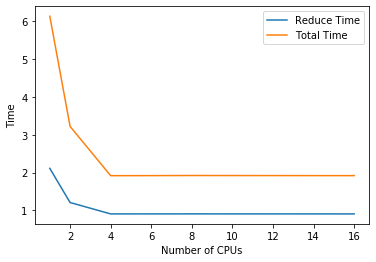

In [2]:
import matplotlib.pyplot as plt

cpus = [1, 2, 4, 8, 16]
reduce_timings = [2.114072799682617, 1.2098281383514404, 0.9086203575134277, 0.909632682800293, 0.9085335731506348]
total_timings = [6.136846542358398, 3.2231738567352295, 1.9196875095367432, 1.9240102767944336, 1.921098232269287]
plt.plot(cpus, reduce_timings)
plt.plot(cpus, total_timings)
plt.xlabel('Number of CPUs')
plt.ylabel('Time')
plt.legend(['Reduce Time', 'Total Time'], loc='upper right')
plt.show()